# Création de cartes statiques relatives à la performance énergétique des logements et au niveau de vie des ménage (visualisation à l'échelle des communes d'Ile-de-France)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

## A) Importation du dataframe Filosofi_dpe_IDF_com et quelques retraitements

In [12]:
Filosofi_dpe_IDF_com = pd.read_csv("~/work/data_science_project/Filosofi_dpe_IDF_com.csv")

In [13]:
# Calcul du ratio "nombre de DPE/nombre de ménages fiscaux":
Filosofi_dpe_IDF_com["ratio_DPE_menage"]=Filosofi_dpe_IDF_com["nombre_dpe"]/Filosofi_dpe_IDF_com["NBMENFISC16"]
Filosofi_dpe_IDF_com2=Filosofi_dpe_IDF_com[Filosofi_dpe_IDF_com["ratio_DPE_menage"]>0.05].reset_index()

In [14]:
# 1) Codage de la variable "proportions de logements énergivores":
Filosofi_dpe_IDF_com2["proportion_energivores"]=Filosofi_dpe_IDF_com2.loc[:,['classe_consommation_energie_F','classe_consommation_energie_G']].sum(axis=1)

In [15]:
# Fonction qui calcule la classe d'énergie majoritaire dans une commune
def maj(x):
    dic = 'A B C D E F G'.split()
    list = [x.classe_consommation_energie_A, x.classe_consommation_energie_B, x.classe_consommation_energie_C, 
            x.classe_consommation_energie_D, x.classe_consommation_energie_E, x.classe_consommation_energie_F,
            x.classe_consommation_energie_G]
    indice = [i for i, item in enumerate(list) if item == max(list)]
    if len(indice) != 0:
        return([ dic[j] for j in indice][len(indice)-1])
    else:
        return 'N'

In [16]:
# Création d'une colonne avec ce maximum
Filosofi_dpe_IDF_com2['CE_Maj'] = Filosofi_dpe_IDF_com2.apply(lambda z: maj(z),  axis=1)

## B) Téléchargement des coordonnées géographiques des communes d'Ile-de-France:

In [8]:
!pip install --upgrade botocore==1.23.26  
!pip install --upgrade urllib3==1.22.0 
!pip install py7zr 
!pip install s3fs 
!git clone https://github.com/InseeFrLab/cartogether.git
%cd ./cartogether
!pip install -r requirements.txt
!pip install .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 138.4 kB/s eta 0:00:0000:0100:02
  Attempting uninstall: jmespath
    Found existing installation: jmespath 1.0.1
    Uninstalling jmespath-1.0.1:
      Successfully uninstalled jmespath-1.0.1
  Attempting uninstall: botocore
    Found existing installation: botocore 1.29.13
    Uninstalling botocore-1.29.13:
      Successfully uninstalled botocore-1.29.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.26.13 requires botocore<1.30.0,>=1.29.13, but you have botocore 1.23.26 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.11
    Uninstalling urllib3-1.26.11:
      Successfully uninstalled urllib3-1.26.11
ERROR: pip's dependency resolver does not currently take into a

In [17]:
import cartiflette.s3

communes_IDF = cartiflette.s3.download_vectorfile_url_all(
    values = ["75","91","92","93","94","95","77","78"],
    level="COMMUNE",
    vectorfile_format="geojson",
    decoupage="departement",
    year=2022)

arrondissements_Paris = cartiflette.s3.download_vectorfile_url_all(
    values = ["75"],
    level="COMMUNE_ARRONDISSEMENT",
    vectorfile_format="geojson",
    decoupage="departement",
    year=2022)

Downloading: : 63.3kiB [00:00, 20.4MiB/s]
Downloading: : 3.68MiB [00:00, 55.1MiB/s]
Downloading: : 360kiB [00:00, 37.2MiB/s]
Downloading: : 807kiB [00:00, 53.2MiB/s]
Downloading: : 724kiB [00:00, 44.9MiB/s]
Downloading: : 2.61MiB [00:00, 58.4MiB/s]
Downloading: : 15.5MiB [00:00, 59.5MiB/s]
Downloading: : 4.38MiB [00:00, 61.6MiB/s]
Downloading: : 223kiB [00:00, 31.2MiB/s]


In [18]:
communes_IDF = communes_IDF[['NOM','INSEE_COM','geometry']]
arrondissements_Paris = arrondissements_Paris[['NOM','INSEE_COG','geometry']]

In [19]:
communes_IDF['INSEE_COM'] = communes_IDF['INSEE_COM'].apply(lambda n: int(n))
arrondissements_Paris['INSEE_COG'] = arrondissements_Paris['INSEE_COG'].apply(lambda n: int(n))

In [20]:
# Jointure avec le dataframe Filosofi_dpe_IDF_com2:

Filosofi_dpe_IDF_com3=pd.merge(communes_IDF,Filosofi_dpe_IDF_com2,left_on="INSEE_COM",right_on="CODGEO",how="left")
Filosofi_dpe_Paris_com3=pd.merge(arrondissements_Paris,Filosofi_dpe_IDF_com2,left_on="INSEE_COG",right_on="CODGEO",how="left")


In [21]:
Filosofi_dpe_IDF_com4 = Filosofi_dpe_IDF_com3.dropna(subset=["geometry"])
Filosofi_dpe_Paris_com4 = Filosofi_dpe_Paris_com3.dropna(subset=["geometry"])

In [23]:
Filosofi_dpe_Paris_com4.head(19)

,NOM,INSEE_COG,geometry,index,CODGEO,LIBGEO,NBMENFISC16,NBPERSMENFISC16,MED16,DEP,...,estimation_ges_quintiles_Q4,estimation_ges_quintiles_Q5,surface_thermique_lot_median,age_logement_median,consommation_energie_median,estimation_ges_median,nombre_dpe,ratio_DPE_menage,proportion_energivores,CE_Maj
0,Paris 3e Arrondissement,75103,"POLYGON ((2.35016 48.86199, 2.35019 48.86203, ...",3,75103,Paris 3e Arrondissement,17727.0,32292.5,31333.000000,75,...,0.207894,0.171179,45.510,67.0,233.120,13.750,2179.0,0.122920,0.223956,E
1,Paris 2e Arrondissement,75102,"POLYGON ((2.34792 48.87069, 2.34827 48.87062, ...",2,75102,Paris 2e Arrondissement,11362.0,20563.0,30566.500000,75,...,0.165480,0.097865,41.215,65.0,229.505,12.205,1124.0,0.098926,0.235765,E
2,Paris 4e Arrondissement,75104,"POLYGON ((2.36849 48.85581, 2.36873 48.85482, ...",4,75104,Paris 4e Arrondissement,13955.0,25585.5,31007.222222,75,...,0.187842,0.168716,49.035,67.0,207.360,12.680,1464.0,0.104909,0.202186,E
3,Paris 5e Arrondissement,75105,"POLYGON ((2.33666 48.83967, 2.33672 48.84011, ...",5,75105,Paris 5e Arrondissement,25976.0,48846.5,33169.333333,75,...,0.188099,0.232980,38.000,66.0,226.440,17.400,1983.0,0.076340,0.222895,E
4,Paris 6e Arrondissement,75106,"POLYGON ((2.33292 48.85934, 2.33339 48.85924, ...",6,75106,Paris 6e Arrondissement,18276.0,34144.5,39062.666667,75,...,0.244198,0.227548,45.875,67.0,237.620,20.465,1982.0,0.108448,0.231584,E
5,Paris 9e Arrondissement,75109,"POLYGON ((2.32589 48.86958, 2.32597 48.87009, ...",9,75109,Paris 9e Arrondissement,29815.0,58708.0,33258.000000,75,...,0.236316,0.168115,49.640,67.0,223.550,15.535,2302.0,0.077209,0.213727,E
6,Paris 10e Arrondissement,75110,"POLYGON ((2.36471 48.88437, 2.36527 48.88433, ...",10,75110,Paris 10e Arrondissement,44701.0,89949.0,25618.000000,75,...,0.198969,0.191495,53.500,47.0,202.845,17.225,3880.0,0.086799,0.159278,E
7,Paris 11e Arrondissement,75111,"POLYGON ((2.37690 48.87205, 2.37701 48.87195, ...",11,75111,Paris 11e Arrondissement,75645.0,139920.0,26810.333333,75,...,0.195844,0.214199,40.200,45.0,221.880,15.880,5775.0,0.076343,0.218874,D
8,Paris 13e Arrondissement,75113,"POLYGON ((2.36420 48.81640, 2.36333 48.81615, ...",13,75113,Paris 13e Arrondissement,81092.0,168159.0,23750.684783,75,...,0.303880,0.238557,44.750,40.0,176.600,24.290,6598.0,0.081364,0.081691,D
9,Paris 8e Arrondissement,75108,"POLYGON ((2.32716 48.88346, 2.32716 48.88323, ...",8,75108,Paris 8e Arrondissement,17591.0,37836.0,40540.000000,75,...,0.287208,0.261822,71.150,67.0,204.480,26.320,2009.0,0.114206,0.178696,D


## C) Création de la carte statique n°1: les niveaux de vie médian par commune

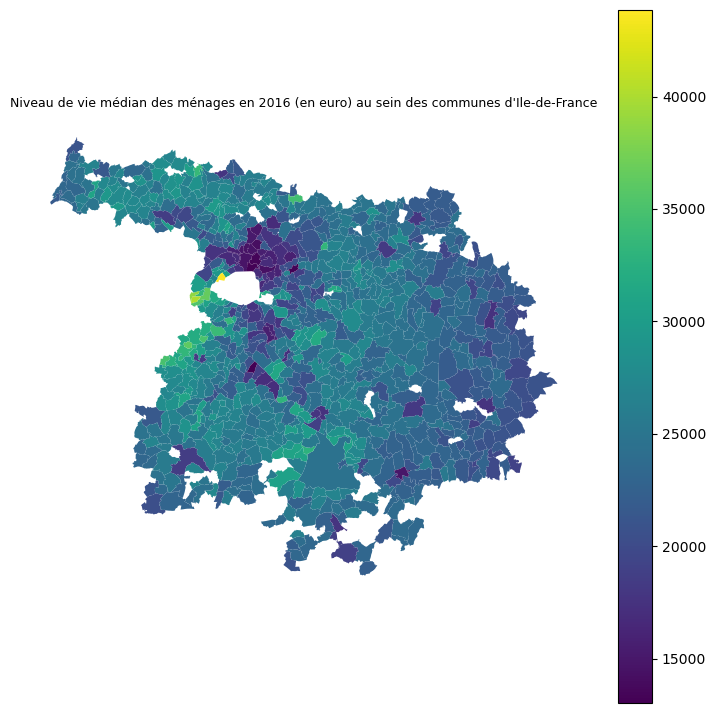

In [32]:
ax = Filosofi_dpe_IDF_com4.plot(figsize=(9,9), column = 'MED16', legend = True)
#plt.title("Niveau de vie médian des ménages (en euro) au sein des communes d'Ile-de-France")
plt.title(label="Niveau de vie médian des ménages en 2016 (en euro) au sein des communes d'Ile-de-France",
          fontsize=9)
ax.set_axis_off()

## D) Création de la carte statique n°2: la proportion de logements énergivores

In [35]:
#conversion en %:
Filosofi_dpe_IDF_com4['proportion_energivores_pct'] = Filosofi_dpe_IDF_com4['proportion_energivores'].apply(lambda x: x*100) 

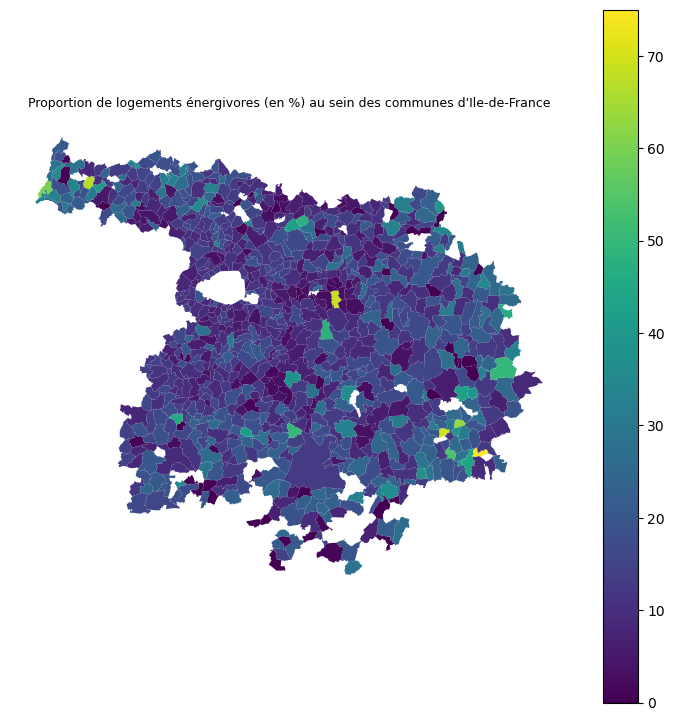

In [37]:
ax = Filosofi_dpe_IDF_com4.plot(figsize=(9,9), column = 'proportion_energivores_pct', legend = True)
plt.title("Proportion de logements énergivores (en %) au sein des communes d'Ile-de-France",
         fontsize=9)
ax.set_axis_off()

## E) Zoom sur Paris et ses arrondissements:

### 1) Carte des niveaux de vie médian par arrondissement:

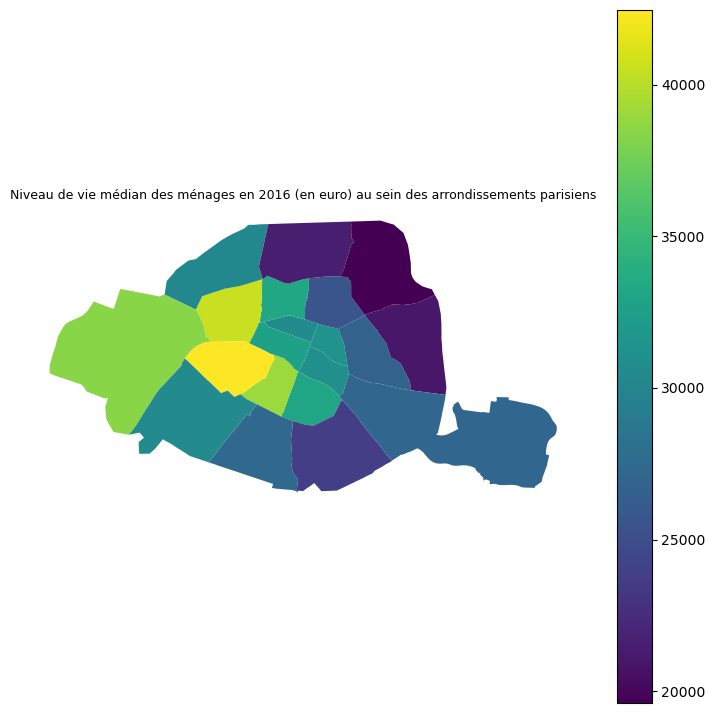

In [38]:
ax = Filosofi_dpe_Paris_com4.plot(figsize=(9,9), column = 'MED16', legend = True)
#plt.title("Niveau de vie médian des ménages (en euro) au sein des communes d'Ile-de-France")
plt.title(label="Niveau de vie médian des ménages en 2016 (en euro) au sein des arrondissements parisiens",
          fontsize=9)
ax.set_axis_off()

### 2) Carte des proportions de logements énergivores par arrondissement:

In [39]:
#conversion en %:
Filosofi_dpe_Paris_com4['proportion_energivores_pct'] = Filosofi_dpe_Paris_com4['proportion_energivores'].apply(lambda x: x*100) 

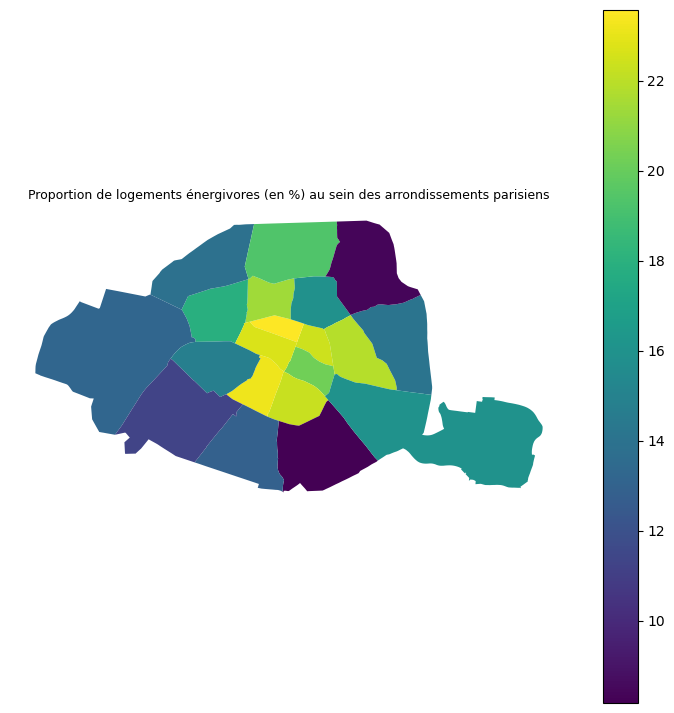

In [40]:
ax = Filosofi_dpe_Paris_com4.plot(figsize=(9,9), column = 'proportion_energivores_pct', legend = True)
plt.title("Proportion de logements énergivores (en %) au sein des arrondissements parisiens",
         fontsize=9)
ax.set_axis_off()